In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import soundscapy as sspy
from soundscapy.utils.parameters import LANGUAGE_ANGLES, PAQ_IDS

import optimize_target as ot
from MultiSkewNorm import MultiSkewNorm

warnings.filterwarnings("ignore")

/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/Users/mitch/Library/CloudStorage/OneDrive-UniversityCollegeLondon/_Fellowship/Papers - Drafts/J2401_JASA_SSID-Single-Index/.venv/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
# Load latest ISD dataset
# data = sspy.isd.load_zenodo()
# Load latest ISD dataset
isd_file = Path("ISD v1.0 Data.csv")

data = pd.read_csv(isd_file, low_memory=False)
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers
# excl_id = list(data.query("LocationID == 'RegentsParkJapan'").query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query("LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)
data

Renaming PAQ columns.
Checking PAQ data quality.
Identified 109 samples to remove.
[6, 9, 13, 30, 32, 46, 190, 213, 229, 244, 296, 412, 413, 428, 464, 485, 655, 734, 739, 762, 766, 780, 1067, 1274, 1290, 1316, 1320, 1338, 1346, 1347, 1397, 1425, 1431, 1446, 1447, 1470, 1485, 1491, 1504, 1505, 1510, 1512, 1517, 1522, 1523, 1527, 1599, 1698, 1734, 1817, 1911, 1948, 2069, 2107, 2109, 2111, 2150, 2199, 2277, 2293, 2384, 2386, 2490, 2523, 2584, 2592, 2695, 2762, 2767, 2783, 2789, 2825, 2826, 2832, 2840, 2856, 2859, 2879, 2883, 2889, 2910, 2932, 2956, 2969, 3031, 3058, 3077, 3124, 3149, 3163, 3185, 3202, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3272, 3302, 3365, 3414, 3491, 3502, 3510, 3517, 3533, 3583]


,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,RA_cp90,RA_cp95,THD_THD,THD_Min,THD_Max,THD_L5,THD_L10,THD_L50,THD_L90,THD_L95
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29
2,CarloV,CarloV2,2CV13,1430,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,Noorderplantsoen,Noorderplantsoen1,NP161,61,2020-03-11 12:42:00,2020-03-11 12:55:00,NaN,NaN,nld,nldSSIDv1,...,2.54,2.00,-3.17,-11.97,59.64,37.87,26.54,6.33,-9.79,-10.34
1694,Noorderplantsoen,Noorderplantsoen1,NP162,63,2020-03-11 12:39:00,2020-03-11 13:00:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,Noorderplantsoen,Noorderplantsoen1,NP162,62,2020-03-11 12:54:00,2020-03-11 12:58:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1696,Noorderplantsoen,Noorderplantsoen1,NP162,64,2020-03-11 12:56:00,2020-03-11 12:59:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
for i, row in data.iterrows():
    lang = row["Language"]
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = (
        sspy.surveys.adj_iso_pl(row[PAQ_IDS], angles, scale=4),
        sspy.surveys.adj_iso_ev(row[PAQ_IDS], angles, scale=4),
    )
    data.loc[i, "ISOPleasant"] = iso_pl
    data.loc[i, "ISOEventful"] = iso_ev

In [4]:
parks = [
    "RegentsParkFields",
    "RegentsParkJapan",
    "Noorderplantsoen",
    "StPaulsCross",
    "MiradorSanNicolas",
    "RussellSq",
    "Noorderplantsoen",
    "MonumentoGaribaldi",
    "CampoPrincipe",
]

not_parks = [
    "MarchmontGarden",
    "PancrasLock",
    "TateModern",
    "PlazaBibRambla",
    "SanMarco",
    "StPaulsRow",
    "CarloV",
    "CamdenTown",
    "EustonTap",
    "TorringtonSq",
]

park_data = data.query("LocationID in @parks")
not_park_data = data.query("LocationID in @not_parks")

rank_on = "sss01"

In [5]:
park_quality = pd.DataFrame(
    park_data.groupby("LocationID")[rank_on].mean().sort_values(ascending=False)
)
park_quality["Rank"] = range(1, len(park_quality) + 1)
park_quality

,sss01,Rank
LocationID,,
RegentsParkJapan,4.617978,1
RegentsParkFields,4.467290,2
CampoPrincipe,4.345455,3
MonumentoGaribaldi,4.156250,4
RussellSq,4.020690,5
MiradorSanNicolas,3.964286,6
StPaulsCross,3.803030,7
Noorderplantsoen,2.412371,8


In [6]:
not_park_quality = pd.DataFrame(
    not_park_data.groupby("LocationID")[rank_on].mean().sort_values(ascending=False)
)
not_park_quality["Rank"] = range(1, len(not_park_quality) + 1)
not_park_quality

,sss01,Rank
LocationID,,
CarloV,4.344828,1
PlazaBibRambla,4.333333,2
TateModern,3.827815,3
StPaulsRow,3.736111,4
SanMarco,3.557895,5
MarchmontGarden,3.548077,6
PancrasLock,3.500000,7
TorringtonSq,3.283186,8
CamdenTown,2.838095,9


In [7]:
quality = pd.DataFrame(
    data.groupby("LocationID")[rank_on].mean().sort_values(ascending=False)
)
quality["Rank"] = range(1, len(quality) + 1)
quality

,sss01,Rank
LocationID,,
RegentsParkJapan,4.617978,1
RegentsParkFields,4.467290,2
CampoPrincipe,4.345455,3
CarloV,4.344828,4
PlazaBibRambla,4.333333,5
MonumentoGaribaldi,4.156250,6
RussellSq,4.020690,7
MiradorSanNicolas,3.964286,8
TateModern,3.827815,9


## Grid Search Target Optimization

In [94]:
# tgt = MultiSkewNorm()
# tgt.define_dp(
#     np.array([0.5, 0.7]),
#     np.array([[0.1, 0.05], [0.05, 0.1]]),
#     np.array([0, -5]),
# )
# tgt.sample()
# r, wspi, spi_ranks, target = ot.target_success(tgt, quality["Rank"], data)
# print(f"Target: {target}")


In [95]:
# omega_grid = ot.construct_omega_grid(
#     variance_range=(0, 0.5),
#     variance_n=10,
#     covariance_range=(-1, 1),
#     covariance_n=10,
# )

# targets = ot.construct_target_grid(
#     omega_grid,
#     xi_range=(-1, 1),
#     xi_n=2,
#     alpha_range=(-1, 1),
#     alpha_n=2,
#     sample_n=100,
# )

# print(len(targets))

In [96]:
# r_res, wspi_res, targets_res = ot.run_grid(
#     targets, quality.sort_index()["Rank"], data, "LocationID"
# )
# plt.plot(r_res, wspi_res, "o")

In [97]:
# comb_res = [r_res[i] * wspi_res[i] for i in range(len(r_res))]
# best_target = targets[np.argmax(comb_res)]
# print(r_res[np.argmax(comb_res)])
# print(wspi_res[np.argmax(comb_res)])

# print(best_target.summary())
# best_target.sspy_plot()

In [98]:
# fig, ax = plt.subplots(figsize=(6, 6))

# sspy.plotting.density(
#     x=best_target.sample_data[:, 0],
#     y=best_target.sample_data[:, 1],
#     ax=ax,
#     incl_scatter=False,
#     density_type="full",
#     title="",
# )

# sspy.plotting.density(
#     sspy.isd.select_location_ids(data, "CarloV"),
#     ax=ax,
#     density_type="simple",
#     title=f"CarloV\nSPI = {best_target.spi(sspy.isd.select_location_ids(data, 'CarloV')[['ISOPleasant', 'ISOEventful']])}",
# )

## `pymoo` Multi-objective Optimization

Defining the optimization problem:

- max $r(ranks_{quality}, ranks_{target})$
- max $mean(SPI_{target}(X_i))$

where $r$ is the rank correlation coefficient, $ranks_{quality}$ and $ranks_{target}$ are the ranks of the quality and target values, and $SPI_{target}(X_i)$ is the SPI for a given target on the data for the $i$-th location. Therefore we are trying to achieve the best correlation between the desired ranking and the ranking produced by $SPI_{target}$ *and* to achieve the highest mean $SPI_{target}$.

$ranks_{quality}$ is pre-defined. $ranks_{target}$ is calculated by sorting the target values and assigning ranks to them. $SPI_{target}$ is calculated for each location and target.


`target_success(target, pre_ranks, data)`

`target` = `MultiSkewNorm`($\xi$, $\Omega$, $\alpha$) parameters

- $\xi = (\xi_x, \xi_y)$,  $-1 \leq \xi \leq 1$
- $\Omega = \begin{pmatrix} var(x) & cov(x, y) \\ cov(y, x) & var(y) \end{pmatrix}$
  - $0 \leq var() \leq 1$
  - $-1 \leq cov() \leq 1$
  - $\Omega$ must be symmetric and positive definite
- $\alpha = (\alpha_x, \alpha_y)$, $-5 \leq \alpha \leq 5$
- $-1 \leq x, y \leq 1$

In `pymoo`, each objective function is supposed to be minimized. Therefore, we need to convert both SPI and r() to minimize problems.

- min $-r(ranks_{quality}, ranks_{target})$
- min $-mean(SPI_{target}(X_i))$

The final objective function is:

- $f_1 = -r(ranks_{quality}, ranks_{target})$
- $f_2 = -mean(SPI_{target}(X_i))$

So our variables to optimize are:

- $-1 \leq \xi_x \leq 1$
- $-1 \leq \xi_y \leq 1$
- $0 \leq var(x) \leq 1$
- $0 \leq var(y) \leq 1$
- $-1 \leq cov(x, y) \leq 1$
- $-5 \leq \alpha_x \leq 5$
- $-5 \leq \alpha_y \leq 5$

Constraint:
- $\Omega$ must be symmetric and positive definite
  - `np.linalg.eigvals(omega) > 0`

### Problem Definition

In [8]:
import pathos
from pymoo.core.callback import Callback
from pymoo.core.problem import ElementwiseProblem, StarmapParallelization
from pymoo.visualization.scatter import Scatter
from pyrecorder.recorder import Recorder
from pyrecorder.writers.streamer import Streamer
from pyrecorder.writers.video import Video
from pymoo.decomposition.asf import ASF


class MyProblem(ElementwiseProblem):
    def __init__(self, data, ranking, **kwargs):
        super().__init__(
            n_var=7,
            n_obj=2,
            n_constr=0,
            xl=np.array([-1, -1, 0, 0, -1, -50, -50]),
            xu=np.array([1, 1, 0.5, 0.5, 1, 50, 50]),
            n_eq_constr=1,
            elementwise_evaluation=True,
            **kwargs,
        )

        self.data = data
        self.ranking = ranking

    def _evaluate(self, X, out, *args, **kwargs):
        h = 1 - int(
            np.all(np.linalg.eigvals(np.array([[X[2], X[4]], [X[4], X[3]]])) > 0)
        )
        out["H"] = h
        if h != 0:
            out["F"] = np.column_stack([0, 0])
            return
        else:
            tgt = MultiSkewNorm()
            tgt.define_dp(
                np.array([X[0], X[1]]),
                np.array([[X[2], X[4]], [X[4], X[3]]]),
                np.array([X[5], X[6]]),
            )
            tgt.sample()
            r, wspi, spi_ranks, target = ot.target_success(tgt, self.ranking, self.data)

            f1 = -r[0]
            f2 = -wspi / 100

            out["F"] = np.column_stack([f1, f2])


class VideoCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.rec = Recorder(Streamer(sleep=0.1))

    def notify(self, algorithm):
        sc = Scatter(
            title="Gen %s" % algorithm.n_gen,
            labels=["spearman", "WSPI"],
        )
        sc.add(algorithm.pop.get("F"))
        sc.do()
        self.rec.record()

In [9]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultMultiObjectiveTermination

algorithm = NSGA2(
    pop_size=150,
    # n_offsprings=50,
    sampling=FloatRandomSampling(),
    crossover=SBX(),
    mutation=PM(),
    eliminate_duplicates=True,
    # callback=VideoCallback()
)

termination = DefaultMultiObjectiveTermination(n_max_gen=30)


### Overall Quality optimization

In [101]:
# initialize the thread pool and create the runner
mp = pathos.helpers.mp
n_process = 12
pool = mp.Pool(n_process)
runner = StarmapParallelization(pool.starmap)

problem = MyProblem(
    data=data, ranking=quality.sort_index()["Rank"], elementwise_runner=runner
)

res = minimize(
    problem, algorithm, termination, seed=42, save_history=True, verbose=True
)

pool.close()

F = res.F
X = res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      2 |  0.000000E+00 |  0.7599240000 |             - |             -
     2 |      300 |      4 |  0.000000E+00 |  0.3333000000 |  0.2611076470 |             f
     3 |      450 |      8 |  0.000000E+00 |  0.000000E+00 |  0.1136363636 |         ideal
     4 |      600 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0234894009 |             f
     5 |      750 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0523076923 |         ideal
     6 |      900 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0301783952 |             f
     7 |     1050 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0124897083 |             f
     8 |     1200 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0321204103 |         ideal
     9 |     1350 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0193905856 |         ideal
    10 |     1500 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0191481630 |         ideal

In [102]:
with Recorder(Video("all_loc_nsga2.mp4")) as rec:
    for entry in res.history:
        sc = Scatter(title="Generation: %s" % entry.n_gen)
        sc.add(entry.pop.get("F"))
        sc.do()
        rec.record()

Best regarding decomposition: Point 18 - [-0.85758514 -2.04333036]


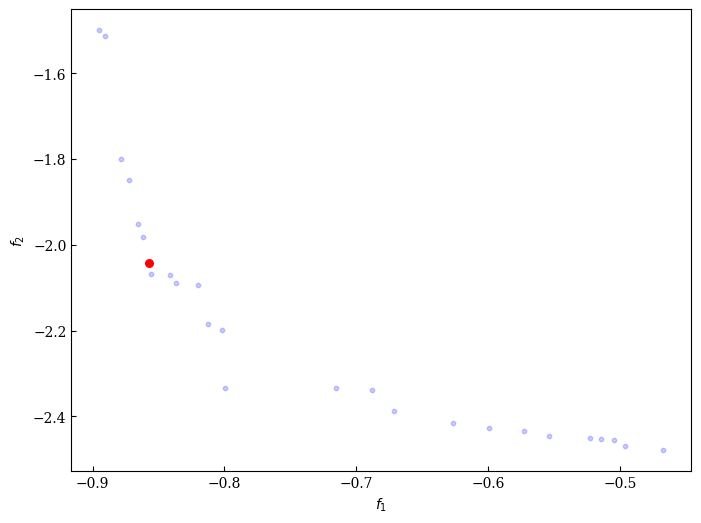

In [103]:
from pymoo.decomposition.asf import ASF

weights = np.array([0.3, 0.7])
decomp = ASF()

I = decomp(res.F, weights).argmin()
print("Best regarding decomposition: Point %s - %s" % (I, res.F[I]))

plot = Scatter()
plot.add(res.F, color="blue", alpha=0.2, s=10)
plot.add(res.F[I], color="red", s=30)
plot.do()
# plot.apply(lambda ax: ax.arrow(0, 0, 0.5, 0.5, color='black',
#                                head_width=0.01, head_length=0.01, alpha=0.4))
plot.show()

Fitted from direct parameters.
Direct Parameters:
xi:    [0.926 0.478]
omega: [[0.31  0.164]
 [0.164 0.391]]
alpha: [ -4.344 -20.281]


None
None


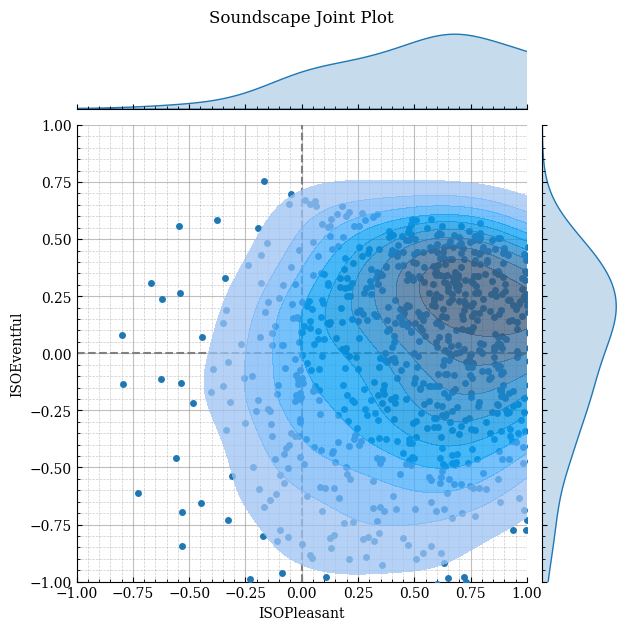

In [104]:
#| label: fig-pymoo-overall-target
#| fig-cap: 
X = res.X[I]
tgt = MultiSkewNorm()
tgt.define_dp(
    np.array([X[0], X[1]]),
    np.array([[X[2], X[4]], [X[4], X[3]]]),
    np.array([X[5], X[6]]),
)
print(tgt.summary())
tgt.sample()
tgt.sspy_plot()

### Park Quality optimization

In [10]:
# initialize the thread pool and create the runner
mp = pathos.helpers.mp
n_process = 12
pool = mp.Pool(n_process)
runner = StarmapParallelization(pool.starmap)

termination = DefaultMultiObjectiveTermination(n_max_gen=50)

park_problem = MyProblem(
    data=park_data, ranking=park_quality.sort_index()["Rank"], elementwise_runner=runner
)

park_res = minimize(
    park_problem, algorithm, termination, seed=42, save_history=True, verbose=True
)

pool.close()

park_F = park_res.F
park_X = park_res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      4 |  0.000000E+00 |  0.7599240000 |             - |             -
     2 |      300 |      4 |  0.000000E+00 |  0.3266340000 |  0.1111111111 |         ideal
     3 |      450 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1440757349 |         ideal
     4 |      600 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0161378878 |         ideal
     5 |      750 |      9 |  0.000000E+00 |  0.000000E+00 |  0.1003752871 |         ideal
     6 |      900 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0680884501 |             f
     7 |     1050 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0077808036 |         ideal
     8 |     1200 |      7 |  0.000000E+00 |  0.000000E+00 |  1.2041241323 |         nadir
     9 |     1350 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0565892369 |         ideal
    10 |     1500 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0246012639 |         ideal

note: looks like this requires more than 30 generations to converge

<Axes: >

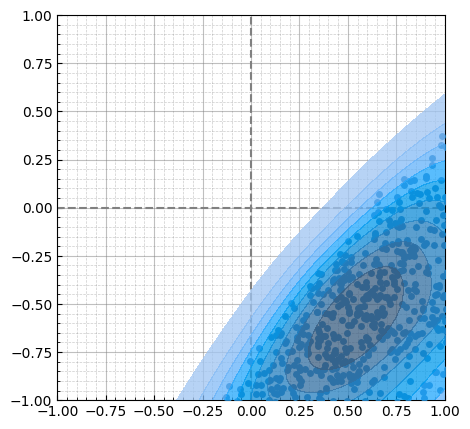

In [28]:
weights = np.array([0.32, 0.68])
decomp = ASF()
park_I = decomp(park_res.history[0].pop.get("F"), weights).argmin()
park_X = park_res.history[0].pop.get("X")[park_I]
park_tgt = MultiSkewNorm()
park_tgt.define_dp(
    np.array([park_X[0], park_X[1]]),
    np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
    np.array([park_X[5], park_X[6]]),
)
park_tgt.sample()
sspy.plotting.density(
    x=park_tgt.sample_data[:,0],
    y=park_tgt.sample_data[:,1],
    title="",
)

In [30]:
with Recorder(Video("park_nsga2.mp4")) as rec:
    for entry in park_res.history:
        sc = Scatter(title="Generation: %s" % entry.n_gen)
        sc.add(entry.pop.get("F"))
        sc.do()
        rec.record()

weights = np.array([0.32, 0.68])
decomp = ASF()

with Recorder(Video("park_nsga2_sspy.mp4")) as rec:
    for entry in park_res.history:
        park_I = decomp(entry.pop.get("F"), weights).argmin()
        park_X = entry.pop.get("X")[park_I]
        park_tgt = MultiSkewNorm()
        park_tgt.define_dp(
            np.array([park_X[0], park_X[1]]),
            np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
            np.array([park_X[5], park_X[6]]),
        )
        park_tgt.sample()
        ss = sspy.plotting.density(
            x=park_tgt.sample_data[:,0],
            y=park_tgt.sample_data[:,1],
            title="Generation: %s" % entry.n_gen,
        )
        rec.record()

Best regarding decomposition: Point 6 - [-0.9047619  -1.81884524]


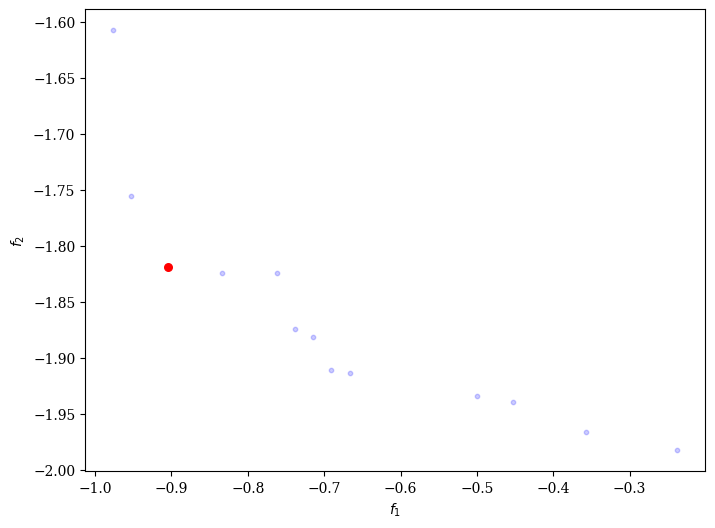

In [13]:
#| label: fig-pymoo-park-pareto
#| fig-cap: Multi-objective optimization Pareto front resulting from fitting to the Park ranking.

from pymoo.decomposition.asf import ASF

weights = np.array([0.32, 0.68])
decomp = ASF()

park_I = decomp(park_res.F, weights).argmin()
print("Best regarding decomposition: Point %s - %s" % (park_I, park_res.F[park_I]))

plot = Scatter()
plot.add(park_res.F, color="blue", alpha=0.2, s=10)
plot.add(park_res.F[park_I], color="red", s=30)
plot.do()
# plot.apply(lambda ax: ax.arrow(0, 0, 0.5, 0.5, color='black',
#                                head_width=0.01, head_length=0.01, alpha=0.4))
plot.show()

Fitted from direct parameters.
Direct Parameters:
xi:    [0.621 0.423]
omega: [[ 0.117 -0.012]
 [-0.012  0.298]]
alpha: [ 2.423 -9.241]


None
None


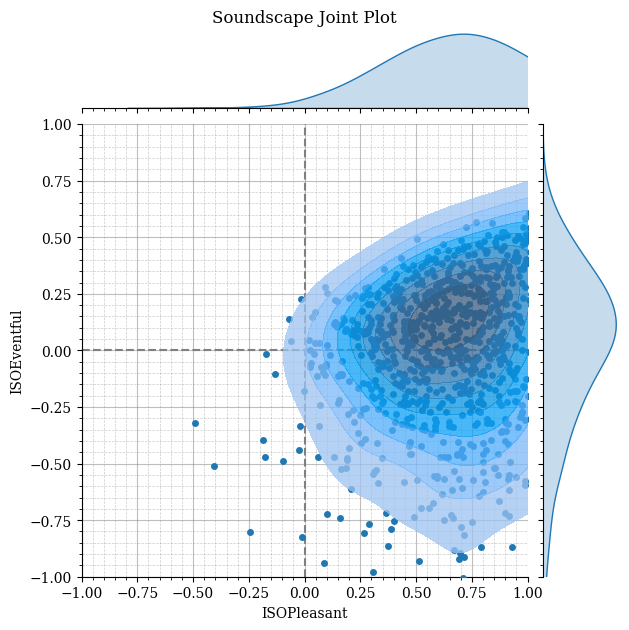

In [14]:
#| label: fig-pymoo-park-target
#| fig-cap: MSN parameters and SCM distribution of the target produced by fitting to the Park ranking.
park_X = park_res.X[park_I]
park_tgt = MultiSkewNorm()
park_tgt.define_dp(
    np.array([park_X[0], park_X[1]]),
    np.array([[park_X[2], park_X[4]], [park_X[4], park_X[3]]]),
    np.array([park_X[5], park_X[6]]),
)
print(park_tgt.summary())
park_tgt.sample()
park_tgt.sspy_plot()

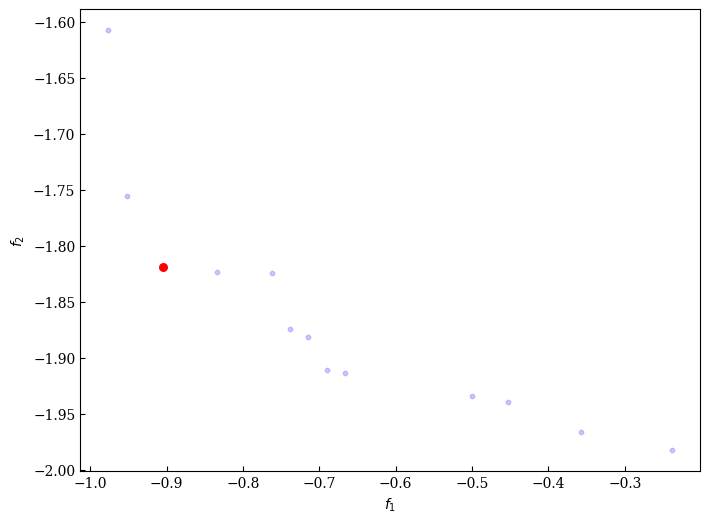

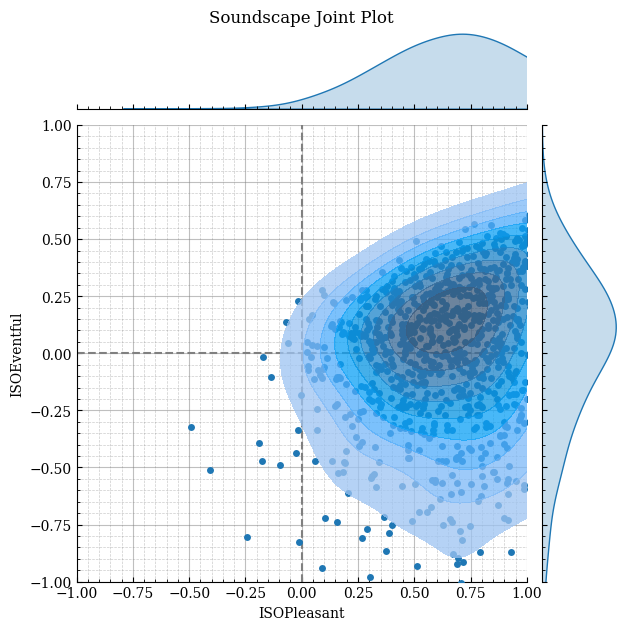

In [17]:
#| label: fig-pymoo-parks
#| fig-cap: "NSGA-II optimization to learn the MSN parameters which produce the Park ranking."
#| fig-subcap:
#|   - "Multi-objective optimization Pareto front."
#|   - "SCM distribution of the derived target distribution."
#| layout-ncol: 2 
import matplotlib.pyplot as plt

plot = Scatter()
plot.add(park_res.F, color="blue", alpha=0.2, s=10)
plot.add(park_res.F[park_I], color="red", s=30)
plot.do()
# plot.apply(lambda ax: ax.arrow(0, 0, 0.5, 0.5, color='black',
#                                head_width=0.01, head_length=0.01, alpha=0.4))
plot.show()
plt.show()

park_tgt.sspy_plot()
plt.show()

### Not Park Optimization

In [109]:
# initialize the thread pool and create the runner
mp = pathos.helpers.mp
n_process = 12
pool = mp.Pool(n_process)
runner = StarmapParallelization(pool.starmap)

np_problem = MyProblem(
    data=not_park_data, ranking=not_park_quality.sort_index()["Rank"], elementwise_runner=runner
)

np_res = minimize(
    np_problem, algorithm, termination, seed=42, save_history=True, verbose=True
)

pool.close()

np_F = np_res.F
np_X = np_res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      2 |  0.000000E+00 |  0.7599240000 |             - |             -
     2 |      300 |      2 |  0.000000E+00 |  0.3732960000 |  0.1666666667 |         ideal
     3 |      450 |      3 |  0.000000E+00 |  0.000000E+00 |  0.2500000000 |         ideal
     4 |      600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.5333333333 |         ideal
     5 |      750 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      900 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1050 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0456974104 |         ideal
     8 |     1200 |      4 |  0.000000E+00 |  0.000000E+00 |  0.2092517852 |         ideal
     9 |     1350 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0303030303 |         ideal
    10 |     1500 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0242819144 |         ideal

In [110]:
with Recorder(Video("not_park_nsga2.mp4")) as rec:
    for entry in np_res.history:
        sc = Scatter(title="Generation: %s" % entry.n_gen)
        sc.add(entry.pop.get("F"))
        sc.do()
        rec.record()

Best regarding decomposition: Point 6 - [-0.93939394 -1.93503175]


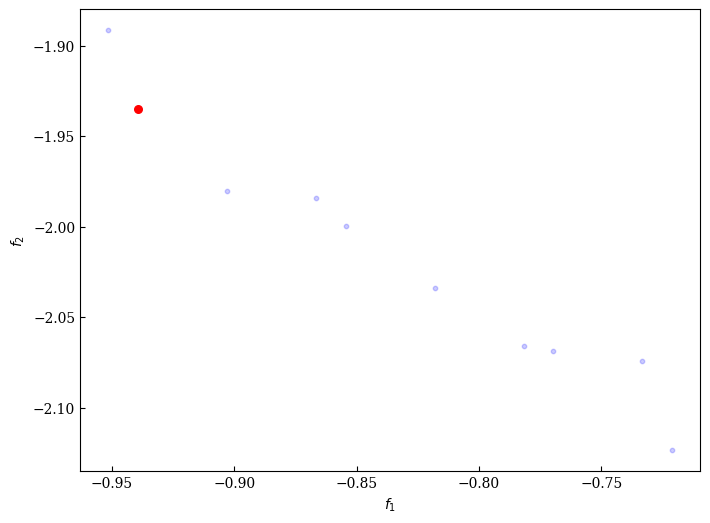

In [111]:
weights = np.array([0.32, 0.68])
decomp = ASF()

np_I = decomp(np_res.F, weights).argmin()
print("Best regarding decomposition: Point %s - %s" % (np_I, np_res.F[np_I]))

plot = Scatter()
plot.add(np_res.F, color="blue", alpha=0.2, s=10)
plot.add(np_res.F[np_I], color="red", s=30)
plot.do()
# plot.apply(lambda ax: ax.arrow(0, 0, 0.5, 0.5, color='black',
#                                head_width=0.01, head_length=0.01, alpha=0.4))
plot.show()

Fitted from direct parameters.
Direct Parameters:
xi:    [0.419 0.556]
omega: [[ 0.068 -0.057]
 [-0.057  0.387]]
alpha: [  1.929 -34.176]


None
None


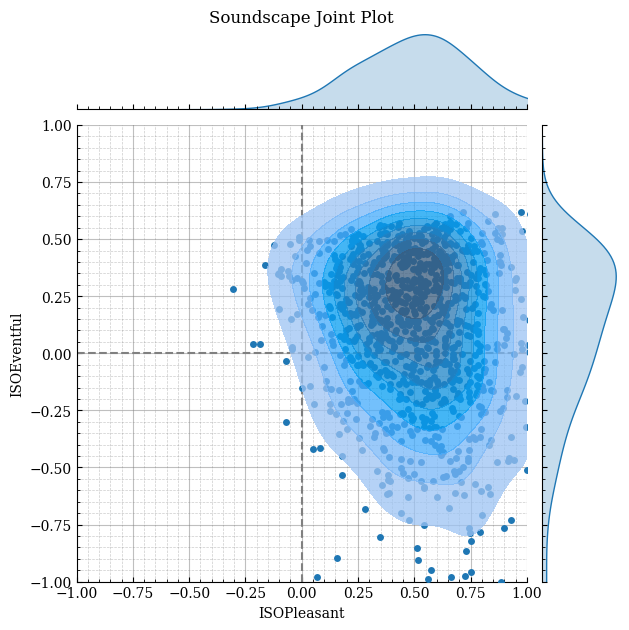

In [112]:
np_X = np_res.X[np_I]
np_tgt = MultiSkewNorm()
np_tgt.define_dp(
    np.array([np_X[0], np_X[1]]),
    np.array([[np_X[2], np_X[4]], [np_X[4], np_X[3]]]),
    np.array([np_X[5], np_X[6]]),
)
print(np_tgt.summary())
np_tgt.sample()
np_tgt.sspy_plot()

## For loop version

In [17]:
# from pymoo.core.termination import NoTermination
# from pymoo.problems.static import StaticProblem
# from pymoo.core.evaluator import Evaluator
# from tqdm.autonotebook import tqdm

# problem = Problem(
#     n_var=7,
#     n_obj=2,
#     n_constr=0,
#     xl=np.array([-1, -1, 0, 0, -1, -5, -5]),
#     xu=np.array([1, 1, 0.25, 0.25, 1, 5, 5]),
#     evaluation_of="auto"
#     )

# # create the algorithm object
# algorithm = NSGA2(pop_size=20)

# # let the algorithm object never terminate and let the loop control it
# termination = NoTermination()

# # create an algorithm object that never terminates
# algorithm.setup(problem, termination=termination)

# # Fix the random seed manually
# np.random.seed(1)

# # until the algorithm has no terminated
# for n_gen in tqdm(range(20), desc='Pop', position=0):
#     # ask the algorithm for the next solution to be evaluated
#     pop = algorithm.ask()

#     # get the design space values of the algorithm
#     X = pop.get("X")

#     # implement your evaluation here
#     f1 = np.zeros(X.shape[0])
#     f2 = np.zeros(X.shape[0])

#     # for i in range(X.shape[0]):
#     #     omega = np.array([[X[i][2], X[i][4]], [X[i][4], X[i][3]]])


#     for i in tqdm(range(X.shape[0]), desc=f'Gen {n_gen}', position=1):
#         tgt = MultiSkewNorm()
#         try:
#             tgt.define_dp(
#                 np.array([X[i][0], X[i][1]]),
#                 np.array([[X[i][2], X[i][4]], [X[i][4], X[i][3]]]),
#                 np.array([X[i][5], X[i][6]]),
#             )
#         except AssertionError:
#             continue
#         tgt.sample()
#         r, wspi, spi_ranks, target = ot.target_success(tgt, quality.sort_index()['Rank'], data)

#         f1[i] =  -r[0]
#         f2[i] = -wspi / 100

#     F = np.column_stack([f1, f2])

#     static = StaticProblem(problem, F=F)
#     Evaluator().eval(static, pop)

#     # returned the evaluated individuals which have been evaluated or even modified
#     algorithm.tell(infills=pop)

#     # print the current generation
#     # print(f"Generation: {algorithm.n_gen}")
#     # print(tgt.summary())
#     # print()

#     # outer.update(1)

# # obtain the result objective from the algorithm
# res = algorithm.result()

# # calculate a hash to show that all executions end with the same result
# print("hash", res.F.sum())

